<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [9]:
import pandas as pd

path = "./data2/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
df = pd.read_csv(path)
print(df.shape)
df.head()

(28332, 24)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [10]:
df['reviews.text'][0]

'I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.'

## Applying NLP

- tokenize the text
- spacy to tokenize

In [10]:
import spacy

nlp = spacy.load('en_core_web_lg')

In [11]:
# function to get lemma
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    STOP_WORDS = nlp.Defaults.stop_words.union(['amazon'])

    for token in doc: 
        if ((token.text.lower() not in STOP_WORDS) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [12]:
df['lemmas'] = df['reviews.text'].apply(get_lemmas)

In [13]:
df['lemmas']

0        [order, 3, item, bad, quality, miss, backup, s...
1                    [bulk, expensive, way, product, like]
2                                 [Duracell, price, happy]
3                      [work, brand, battery, well, price]
4                      [battery, long, last, price, great]
                               ...                        
28327    [get, 2, 8, yr, old, twin, 11, yr, old, well, ...
28328    [buy, niece, Christmas, gift.she, 9, year, old...
28329    [nice, light, internet, browsing, keep, email,...
28330    [Tablet, absolutely, want, watch, tv, show, mo...
28331    [ninety, dollar, expectionation, low, good, ta...
Name: lemmas, Length: 28332, dtype: object

In [14]:
df['lemmas'][0]

['order',
 '3',
 'item',
 'bad',
 'quality',
 'miss',
 'backup',
 'spring',
 'pc',
 'aluminum',
 'battery',
 'work']

## Fit Gensim LDA Topic model on Amazon Reviews

In [15]:
import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

In [16]:
id2word = corpora.Dictionary(df['lemmas'])

In [17]:
print(id2word)

Dictionary(9703 unique tokens: ['3', 'aluminum', 'backup', 'bad', 'battery']...)


In [18]:
corpus = [id2word.doc2bow(doc) for doc in df['lemmas']]

In [19]:
len(corpus)

28332

In [20]:
lda = LdaMulticore(corpus=corpus,
                  id2word=id2word,
                  num_topics=5,
                  passes=10,
                  workers=12,
                  random_state=812)

In [21]:
lda.print_topics()

[(0,
  '0.040*"good" + 0.022*"kindle" + 0.022*"great" + 0.019*"read" + 0.018*"work" + 0.017*"love" + 0.014*"book" + 0.013*"price" + 0.012*"fire" + 0.011*"screen"'),
 (1,
  '0.035*"old" + 0.034*"love" + 0.031*"year" + 0.022*"buy" + 0.020*"tablet" + 0.013*"use" + 0.012*"purchase" + 0.011*"app" + 0.011*"like" + 0.011*"game"'),
 (2,
  '0.072*"great" + 0.041*"tablet" + 0.035*"kid" + 0.026*"love" + 0.025*"use" + 0.018*"easy" + 0.017*"buy" + 0.017*"app" + 0.017*"gift" + 0.015*"price"'),
 (3,
  '0.042*"tablet" + 0.019*"easy" + 0.016*"nice" + 0.016*"good" + 0.016*"use" + 0.015*"read" + 0.014*"light" + 0.014*"great" + 0.013*"book" + 0.013*"Kindle"'),
 (4,
  '0.056*"battery" + 0.031*"tablet" + 0.026*"great" + 0.024*"good" + 0.024*"price" + 0.022*"buy" + 0.019*"love" + 0.018*"use" + 0.016*"long" + 0.014*"work"')]

In [22]:
import re

words = [re.findall(r'"([^"]*)"', t[1]) for t in lda.print_topics()]

In [23]:
words

[['good',
  'kindle',
  'great',
  'read',
  'work',
  'love',
  'book',
  'price',
  'fire',
  'screen'],
 ['old',
  'love',
  'year',
  'buy',
  'tablet',
  'use',
  'purchase',
  'app',
  'like',
  'game'],
 ['great',
  'tablet',
  'kid',
  'love',
  'use',
  'easy',
  'buy',
  'app',
  'gift',
  'price'],
 ['tablet',
  'easy',
  'nice',
  'good',
  'use',
  'read',
  'light',
  'great',
  'book',
  'Kindle'],
 ['battery',
  'tablet',
  'great',
  'good',
  'price',
  'buy',
  'love',
  'use',
  'long',
  'work']]

In [24]:
topics = [' '.join(t[0:5]) for t in words]

In [25]:
topics

['good kindle great read work',
 'old love year buy tablet',
 'great tablet kid love use',
 'tablet easy nice good use',
 'battery tablet great good price']

In [26]:
for id, t in enumerate(topics):
    print(f'-----Topic {id} ------')
    print(t, end="\n\n")

-----Topic 0 ------
good kindle great read work

-----Topic 1 ------
old love year buy tablet

-----Topic 2 ------
great tablet kid love use

-----Topic 3 ------
tablet easy nice good use

-----Topic 4 ------
battery tablet great good price



In [27]:
df.columns

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs',
       'lemmas'],
      dtype='object')

In [28]:
df['reviews.rating']

0        3
1        4
2        5
3        5
4        5
        ..
28327    5
28328    4
28329    5
28330    5
28331    4
Name: reviews.rating, Length: 28332, dtype: int64

In [29]:
import pyLDAvis.gensim

In [30]:
pyLDAvis.enable_notebook()

In [32]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.048403  0.095966       1        1  31.098444
1     -0.036534  0.006673       2        1  20.276562
2     -0.104274 -0.065267       3        1  17.388748
0      0.107491  0.044134       4        1  15.831956
3      0.081721 -0.081507       5        1  15.404290, topic_info=         Term         Freq        Total Category  logprob  loglift
4     battery  6523.000000  6523.000000  Default  30.0000  30.0000
22      great  8857.000000  8857.000000  Default  29.0000  29.0000
591       old  2777.000000  2777.000000  Default  28.0000  28.0000
98       year  2417.000000  2417.000000  Default  27.0000  27.0000
181       kid  3273.000000  3273.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
19      price   490.885590  4661.197754   Topic5  -4.6270  -0.3803
86       love   470.700958  7037.818359   Topic5  -4.6690  -0.8343
236    device   279.686279  1302.313477   Topic5  -5.1895   0.3323
2782  feature   250.440674   809.569397   Topic5  -5.3000   0.6972
181       kid   318.672852  3273.150635   Topic5  -5.0590  -0.4588

[460 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
466       1  0.206298     1
466       2  0.553055     1
466       3  0.197520     1
466       4  0.021947     1
466       5  0.021947     1
...     ...       ...   ...
98        5  0.001655  year
1453      1  0.221582    yr
1453      2  0.755560    yr
1453      3  0.021795    yr
1453      4  0.003632    yr

[1129 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 1, 4])

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling

In [33]:
doc_topics = [lda[doc] for doc in corpus]

In [35]:
doc_topics[0]

[(0, 0.39862075),
 (1, 0.2597563),
 (2, 0.015566874),
 (3, 0.015635503),
 (4, 0.31042063)]

In [36]:
def update(doc):
    d_dist = {k:0 for k in range(0, 5)}
    for t in doc:
        d_dist[t[0]] = t[1]
    return d_dist

new_distro = [update(d) for d in doc_topics]

In [37]:
dft = pd.DataFrame.from_records(new_distro)
dft

,0,1,2,3,4
0,0.398621,0.259756,0.015567,0.015636,0.310421
1,0.034026,0.034128,0.034208,0.034055,0.863583
2,0.050758,0.050607,0.050487,0.050524,0.797624
3,0.034515,0.033514,0.033648,0.033569,0.864754
4,0.033646,0.033441,0.034029,0.033563,0.865321
...,...,...,...,...,...
28327,0.014810,0.941677,0.014466,0.014561,0.014485
28328,0.022435,0.599608,0.022698,0.022381,0.332877
28329,0.361364,0.000000,0.000000,0.454176,0.172334
28330,0.590322,0.189439,0.000000,0.202370,0.000000


In [38]:
dft.columns = topics

In [39]:
dft.head()

,good kindle great read work,old love year buy tablet,great tablet kid love use,tablet easy nice good use,battery tablet great good price
0,0.398621,0.259756,0.015567,0.015636,0.310421
1,0.034026,0.034128,0.034208,0.034055,0.863583
2,0.050758,0.050607,0.050487,0.050524,0.797624
3,0.034515,0.033514,0.033648,0.033569,0.864754
4,0.033646,0.033441,0.034029,0.033563,0.865321


In [41]:
df['primary_topic'] = dft.idxmax(axis=1)

In [42]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,lemmas,primary_topic
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...","[order, 3, item, bad, quality, miss, backup, s...",good kindle great read work
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...","[bulk, expensive, way, product, like]",battery tablet great good price
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...","[Duracell, price, happy]",battery tablet great good price
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...","[work, brand, battery, well, price]",battery tablet great good price
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...","[battery, long, last, price, great]",battery tablet great good price


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

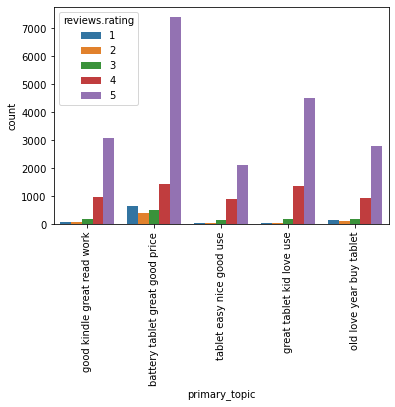

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(x="primary_topic", hue="reviews.rating", data=df)
plt.xticks(rotation=90)